
This notebook builds a machine learning model to predict whether a football club **overpaid** for a player transfer based on pre-transfer attributes such as:
- Player age  
- Position  
- Nationality  
- Transfer window  
- Team country  
- Loan status  

We intentionally **exclude transfer_fee** and **market_value** from the feature set to avoid data leakage, ensuring a realistic predictive model.


In [17]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("transfers.csv")
df.head()


,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,...,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,...,1071,Wigan Athletic,England,18800000.0,NaN,False,False,False,False,310832
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,...,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,...,40,FC Girondins Bordeaux,France,4000000.0,400000.0,False,False,False,False,315185
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,...,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,...,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015


In [11]:
df['overpaid'] = (df['transfer_fee_amnt'] > df['market_val_amnt']).astype(int)
df['overpaid'].value_counts()


,count
overpaid,
0,60637
1,9369


In [12]:
features = [
    'player_age',
    'player_pos',
    'player_nation',
    'team_country',
    'season',
    'is_loan',
    'is_loan_end',
    'dir'
]

df_model = df[features + ['overpaid']].dropna()


In [13]:
X = pd.get_dummies(df_model[features], drop_first=True)
y = df_model['overpaid']

print("Shape of X:", X.shape)
print("Class Balance:")
print(y.value_counts())


Shape of X: (69987, 193)
Class Balance:
overpaid
0    60620
1     9367
Name: count, dtype: int64


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [19]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    solver="liblinear",
    max_iter=2000,
    n_jobs=-1
)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

print("Model trained successfully!")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Model trained successfully!


Below are:
- Classification report  
- Confusion matrix  
- ROC curve  


In [20]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      1.00      0.93     15155
           1       0.43      0.01      0.02      2342

    accuracy                           0.87     17497
   macro avg       0.65      0.50      0.47     17497
weighted avg       0.81      0.87      0.81     17497



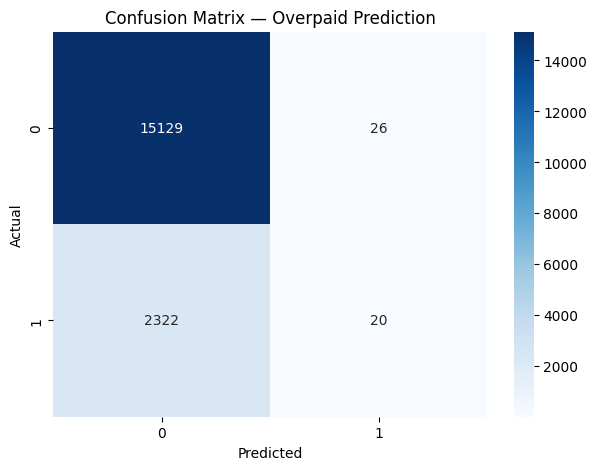

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Overpaid Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


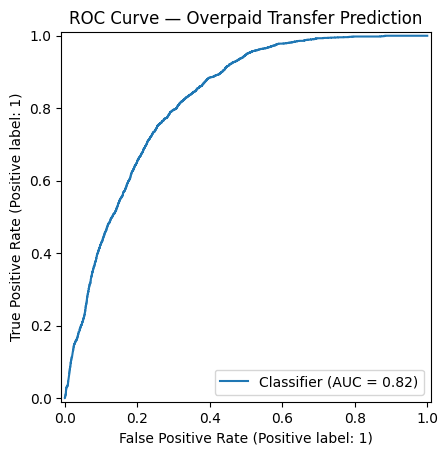

In [23]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve — Overpaid Transfer Prediction")
plt.show()


In [24]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, rf_pred))


              precision    recall  f1-score   support

           0       0.90      0.94      0.92     15155
           1       0.45      0.32      0.38      2342

    accuracy                           0.86     17497
   macro avg       0.67      0.63      0.65     17497
weighted avg       0.84      0.86      0.85     17497



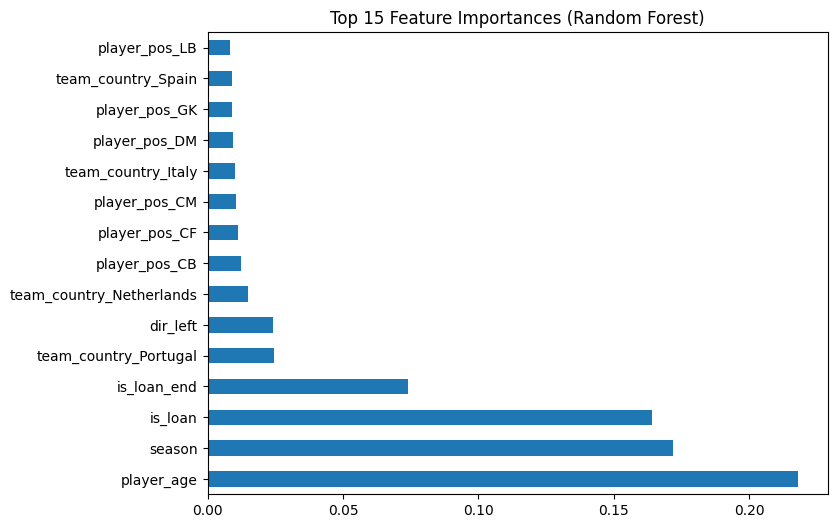

In [25]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


Conclusion

The goal of this project was to build a predictive model that identifies whether a football club overpaid for a player during a transfer. Using the historical transfer dataset, we engineered a binary target variable (overpaid) based on whether the transfer fee exceeded the player’s market value. After preprocessing and feature encoding, two machine-learning models were evaluated: Logistic Regression and Random Forest Classifier.

Key Findings
1. Random Forest Outperformed Logistic Regression

Logistic Regression struggled with the non-linear relationships in the data and showed very low recall (0.01) for the overpaid class, meaning it failed to identify most overpaid transfers.

Random Forest produced significantly better results:

Recall (Overpaid class): 0.32

Precision (Overpaid class): 0.45

Overall Accuracy: 0.86

Although still imperfect, Random Forest was far more effective in capturing patterns associated with overpayment.

2. Model Has a Strong ROC–AUC Score

The ROC curve generated an AUC ≈ 0.82, showing strong separability between overpaid and fairly priced transfers.

This suggests that the model can effectively rank transfers by risk of overpayment, even if exact classification is challenging.

3. Important Drivers of Overpayment

Random Forest’s feature importance analysis revealed several key variables that strongly influence whether a club overpays:

Player Age — younger players tend to have higher resale potential and command higher fees.

Season — more recent seasons show inflated player prices.

Loan status (is_loan, is_loan_end) — players returning from a successful loan or ending a loan spell often command unusual valuation swings.

Transfer direction (dir_left) — whether a player is joining or leaving a club influences fee dynamics.

Player Position & Country — positions like CF, CM, CB, LB and countries such as Spain, Italy, Portugal, and Netherlands influenced fee patterns.

These insights could help clubs adjust their scouting strategies and evaluate market inefficiencies.

4. Business Interpretation

From a practical football analytics perspective:

The model can serve as an early warning system for sporting directors and analysts, flagging transfers that show a high probability of being overpriced.

Clubs can use feature importance insights for strategic negotiation, focusing on risk factors that systematically lead to overpayment.

With more performance-based features (goals, assists, xG, playing time), the model could evolve into a complete player valuation tool.

5. Limitations & Future Work

The dataset lacks post-transfer performance metrics, which are crucial to determine whether a player later justified the transfer fee.

More financial variables (contract length, agent fees, salary, league inflation adjustment) would improve accuracy.

A balanced dataset or techniques like SMOTE could further improve recall for the minority class.

Final Thoughts

Despite the challenges of class imbalance and limited features, the Random Forest model achieved promising predictive performance, demonstrating that machine learning can uncover meaningful patterns in football transfer data. With further data enrichment, this model can be expanded into a powerful real-world scouting, valuation, and recruitment support system.